***https://drive.google.com/file/d/1XqU6_oH2xhfF5-HnXMK3u7rDUy0x0Bg8/view?usp=sharing***

Roll Number: 21100157

### IMAGE COMPLETION

Image Completion is the task of filling missing parts of a given image with the help of information from the known parts of the image. This is an application that takes an image with a missing part as input and gives a completed image as the result.

We will be using Autoencoder to do this task. We will train our network on Images with missing parts passed with true images so that autoencoder can minimize the ture image and corrupted image. 

### Imports

In [ ]:
import os
import cv2
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import tensorflow as tf
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape
from keras.layers import Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam, SGD, Adagrad
from keras.utils import plot_model
from skimage.io import imread
from PIL import Image, ImageDraw

from google_drive_downloader import GoogleDriveDownloader as gdd
import os.path
import os
from random import shuffle
import random
import copy
from matplotlib import pyplot

### Data

The data we are using is [Flickr-Faces-HQ Dataset (FFHQ)](https://github.com/NVlabs/ffhq-dataset). It is an unlabelled dataset used for training GANs and other image generation algorithms. The original dataset has images of size 1024 by 1024 but we have only taken 128 by 128 images. 

Mounting your google drive.

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


Downloading dataset

In [ ]:
# Dataset link: https://tinyurl.com/hw04dataset
if not os.path.isfile('/content/ffhq-dataset.zip'):
  gdd.download_file_from_google_drive(file_id='1lhIylJPa9H3yS0iGyYZqK01JtYRQvjr1', dest_path='/content/ffhq-dataset.zip', unzip=False)

Unzipping the data file to load it locally in the colab runtime. You can see your unzipped files by clicking the folder icon on left side of your colab.

In [ ]:
# replace this your google drive path of the zip file of dataset provided with this homework
if not os.path.isdir('/content/data'):
  !unzip -o -q "/content/ffhq-dataset.zip" -d "/content/data/"

In [ ]:
# data folder path in colab runtime enviroment
DATA_FOLDER = '/content/data'

# fetching all the filenmaes to read them later in generator
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.png')))

# total images in directory
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 70000


### Data Generator

The dataset is quite large (70000 images) which makes it impossible to load it all at the same time in computer memory. In you assignment 03 you implemented a custom generator function to load the images in batches, here we are going to do the same. Instead of returning the images and its labels, here we will return tuple <i>(corrupted_images_batch, original_images_batch)</i> from the generator where the corrupted images are the same images as the original but a small square is removed from them.

Below you will create a function to remove a portion of image. This is basically the same as drawing a black square on the image. You function will take a numpy image and return the numpy image with black square on it. 


You images will look somehting like this. The square drawn here is 28x28 (you can be confortable with the dimensions) and it is drawn at a random location with-in the image.

![picture](https://drive.google.com/uc?export=view&id=1qIlWIj1K_qjxoGTUJYeVbiLztnyMOVP_)


<i>HINT: You can use ImageDraw function of PIL</i>

In [ ]:
def draw_square_on_image(image):
    
    output_img = copy.deepcopy(image) # making deep copy of original image
    
    ######################## WRITE YOUR CODE BELOW ########################

    # Turning the pixel values of the 28 x 28 pixels to black square randomly (I directly modified the numpy array values to draw black square randomly)
    s1_rand = random.randint(0, 100)
    s1 = s1_rand
    s2 = s1 + 28
    e1_rand = random.randint(0, 100)
    e1 = e1_rand
    e2 = e1 + 28
    output_img[s1 : s2, e1 : e2] = (0, 0, 0)

    ########################### END OF YOUR CODE ##########################

    return output_img

If you are not fimiliar with generators in python you can a look at it [here](https://realpython.com/introduction-to-python-generators/).

As mentioned above, below generator will return a tuple of <i>(corrupted_images_batch, original_images_batch)</i>.

In [ ]:
def preprocessing_norm(images):
  return np.divide(images, 255)

In [ ]:
def custom_image_generator(files, data_instances, batch_size = 64):

    ######################## WRITE YOUR CODE BELOW ########################

  while True:
    proc_batch = []
    batch_input = []
    shuffle(files)
    for i in range(len(files)):
      img = cv2.imread(files[i])
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      proc_batch.append(img)

      temp = copy.deepcopy(img) # making deep copy of original image
      addSquare = draw_square_on_image(temp)
      batch_input.append(addSquare)

      if (len(proc_batch) == batch_size):
        proc_batch = preprocessing_norm(proc_batch)
        batch_input = preprocessing_norm(batch_input)
        corrupted_images_batch = np.array(batch_input)
        original_images_batch = np.array(proc_batch)

  ########################### END OF YOUR CODE ##########################

        yield (corrupted_images_batch, original_images_batch)
        proc_batch = []
        batch_input = []

Utility function to display grid of images.

In [ ]:
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im)
        ax.axis("off")
    
    plt.suptitle(title_text, fontsize=20)
    plt.show()

In [ ]:
# create generator object
test_generator = custom_image_generator(filenames, 7000)

Displaying sample images from batch generator.

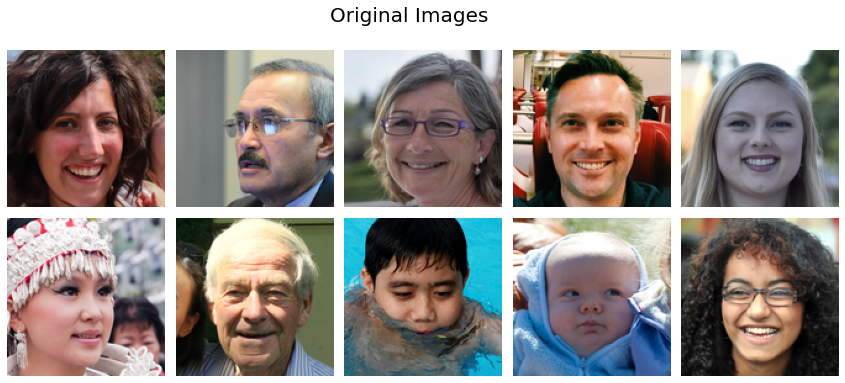

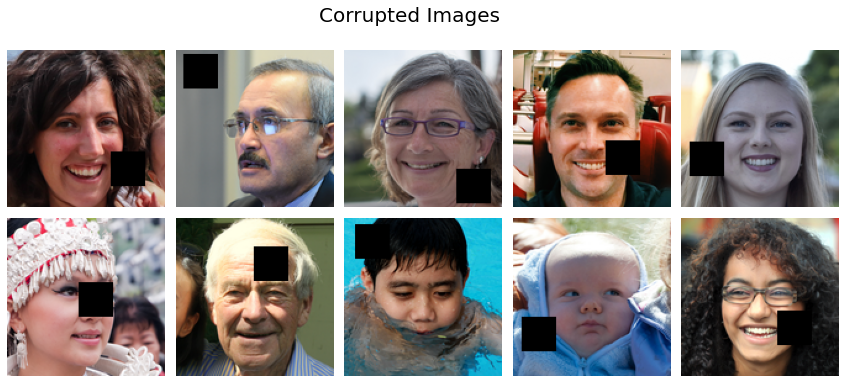

In [ ]:
# get first batch of images
(corrupted_images_batch, orig_images_batch) = next(test_generator)

# only displaying 10 images from both batch
display_image_grid(orig_images_batch[:10], 2, 5, "Original Images")
display_image_grid(corrupted_images_batch[:10], 2, 5, "Corrupted Images")

In [ ]:
INPUT_DIM = (128, 128, 3) # Image dimension
Z_DIM = 700             # Dimension of the latent vector (z)

## Building the Model

#### Encoder

Below you will create the model for the encoder. The architecture of the Encoder consists of a stack of convolutional layers followed by a dense (fully connected) layer which outputs a vector of size <b>Z_DIM</b>. The whole image of size 128x128x3 is decoed into this latent space vector of size <b>Z_DIM</b>.

for i=1 to num_conv:
  - add Covn Layer (filter_size = 32, stride = 2, padding = 'same')
  - add LeakeyReLU

end
- add Dense() (with no activation function)

NOTE: You can also experiment with the number of feature maps, kernel size and strides for each of the conv layer.

You can refer to this [link](https://blog.keras.io/building-autoencoders-in-keras.html) to see how to create autoencoer model in keras.

In [ ]:
ae_encoder = None # initialized below
ae_encoder_output = None # initialized below
ae_encoder_input = Input(shape=INPUT_DIM, name='ae_encoder_input')

######################## WRITE YOUR CODE BELOW ########################

filters = [35, 70, 105, 140]
kernels = [3, 3, 3, 3]
strides = [2, 2, 2, 2]
ae = ae_encoder_input

for i in range(4):
  ae = Conv2D(filters = filters[i], 
             kernel_size = kernels[i], 
             strides = strides[i], 
             padding = 'same', 
             name = 'ae_encoder_input_conv_layer' + str(i))(ae)
  ae = LeakyReLU()(ae)

latentVectorReshaperHelper = K.int_shape(ae)[1:] 
ae = Flatten()(ae)

ae_encoder_output = Dense(Z_DIM, name='ae_encoder_output_dense_layer')(ae)

ae_encoder = Model(inputs=ae_encoder_input, outputs=ae_encoder_output)

########################### END OF YOUR CODE ##########################

ae_encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_encoder_input (InputLayer [(None, 128, 128, 3)]     0         
_________________________________________________________________
ae_encoder_input_conv_layer0 (None, 64, 64, 35)        980       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 35)        0         
_________________________________________________________________
ae_encoder_input_conv_layer1 (None, 32, 32, 70)        22120     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 70)        0         
_________________________________________________________________
ae_encoder_input_conv_layer2 (None, 16, 16, 105)       66255     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 105)       0     

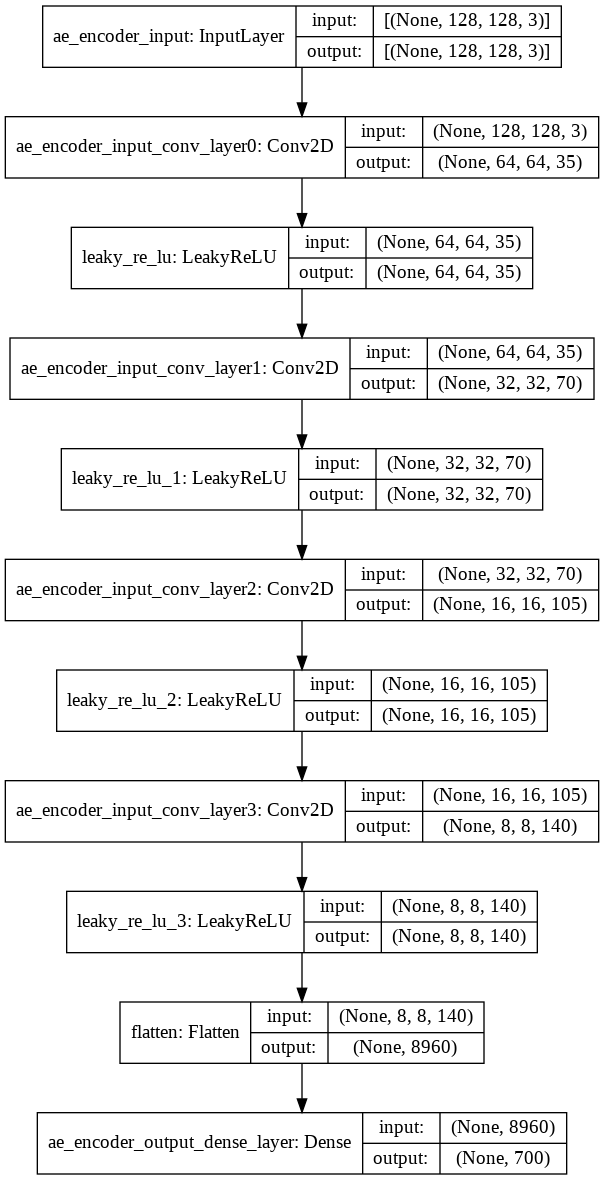

In [ ]:
tf.keras.utils.plot_model(ae_encoder, show_shapes=True)

#### Decoder

Just like the encoder you will create the model for the decoder. This model will be the exact mirror of encoder model, but that is not mandatory.

Since the function of the Decoder to reconstruct the image from the latent vector. Therefore, it is necessary to define the decoder so as to increase the size of the activations gradually through the network. This can be achieved through the  [Conv2DTransponse](https://keras.io/layers/convolutional/#conv2dtranspose) layer. This layer produces an output tensor double the size of the input tensor in both height and width. The input to the encoder is the vector of size <b>Z_DIM</b> and output will be a image of size <b>INPUT_DIM</b>. Your final decoder will look something like this: 

<center>

![picture](https://drive.google.com/uc?export=view&id=1QGaPm7byp7YOZqrZx9ARX9hPBVHB9rq5)

</center>

Again, you can experiment with the number of layers, feature size, kernel size and stride of conv layers.

<i>NOTE: Unlike the encoder, there will the activaiton function for decoder, as it will be outputing the image. And we want our pixel values between zero and one. </i>


In [ ]:
ae_decoder = None # initialized below
ae_decoder_output = None # initialized below

######################## WRITE YOUR CODE BELOW ########################

filters = [105, 70, 35, 3]
kernels = [3, 3, 3, 3]
strides = [2, 2, 2, 2]

ae_decoder_input = Input(shape=(Z_DIM,), name='ae_decoder_input')
ae = Dense(np.prod(latentVectorReshaperHelper))(ae_decoder_input)
ae = Reshape(latentVectorReshaperHelper)(ae)

for i in range(4):
  ae = Conv2DTranspose(filters = filters[i],
                      kernel_size = kernels[i],
                      strides = strides[i],
                      padding = 'same',
                      name = 'ae_decoder_output_dense_layer' + str(i))(ae)
  if i < 4 - 1:
    ae = LeakyReLU()(ae)
  else:
    ae = Activation('sigmoid')(ae)

ae_decoder_output = ae
ae_decoder = Model(inputs=ae_decoder_input, outputs=ae_decoder_output)

########################### END OF YOUR CODE ##########################

ae_decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_decoder_input (InputLayer [(None, 700)]             0         
_________________________________________________________________
dense (Dense)                (None, 8960)              6280960   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 140)         0         
_________________________________________________________________
ae_decoder_output_dense_laye (None, 16, 16, 105)       132405    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 105)       0         
_________________________________________________________________
ae_decoder_output_dense_laye (None, 32, 32, 70)        66220     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 70)        0   

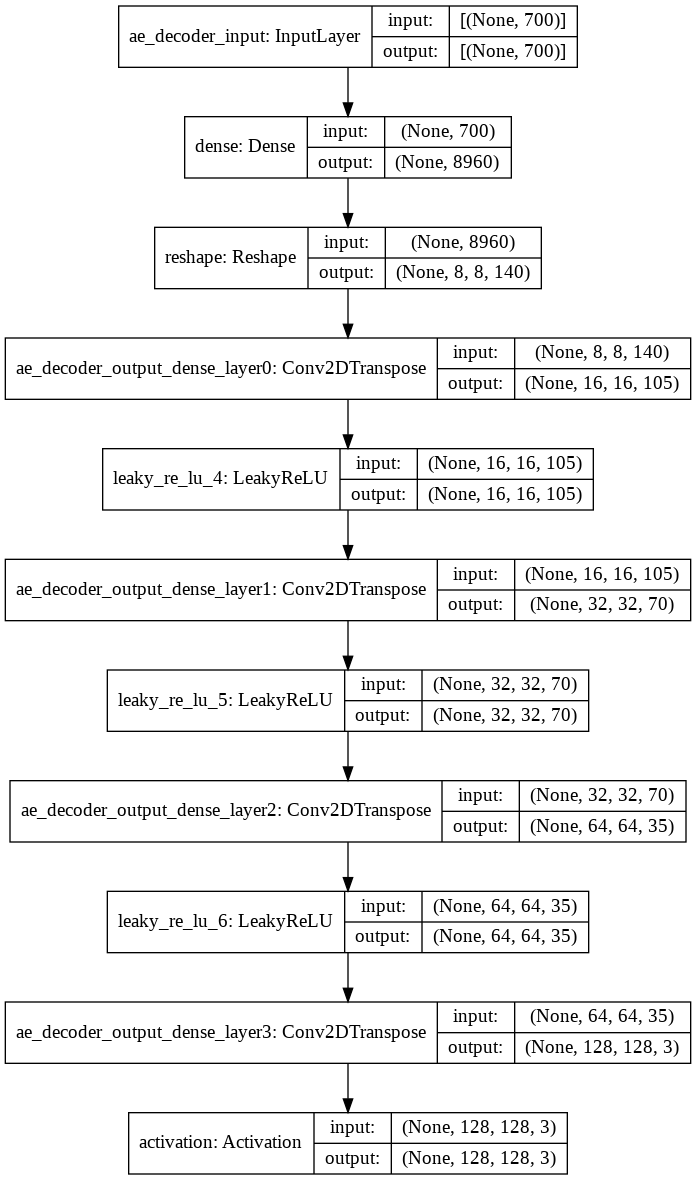

In [ ]:
tf.keras.utils.plot_model(ae_decoder, show_shapes=True)

#### Attaching the Decoder to the Encoder

Finally, here we connect the encoder to the docoder.

In [ ]:
autoencoder_model = None # initialized below

######################## WRITE YOUR CODE BELOW ########################

# The input of the autoencoder will be the same as of encoder
ae_input = ae_encoder_input

# The output of the autoencoder will be the output of decoder, when passed encoder input
ae_output = ae_decoder(ae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
autoencoder_model = Model(inputs=ae_input, outputs=ae_output)

########################### END OF YOUR CODE ##########################

autoencoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_encoder_input (InputLayer [(None, 128, 128, 3)]     0         
_________________________________________________________________
ae_encoder_input_conv_layer0 (None, 64, 64, 35)        980       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 35)        0         
_________________________________________________________________
ae_encoder_input_conv_layer1 (None, 32, 32, 70)        22120     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 70)        0         
_________________________________________________________________
ae_encoder_input_conv_layer2 (None, 16, 16, 105)       66255     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 105)       0   

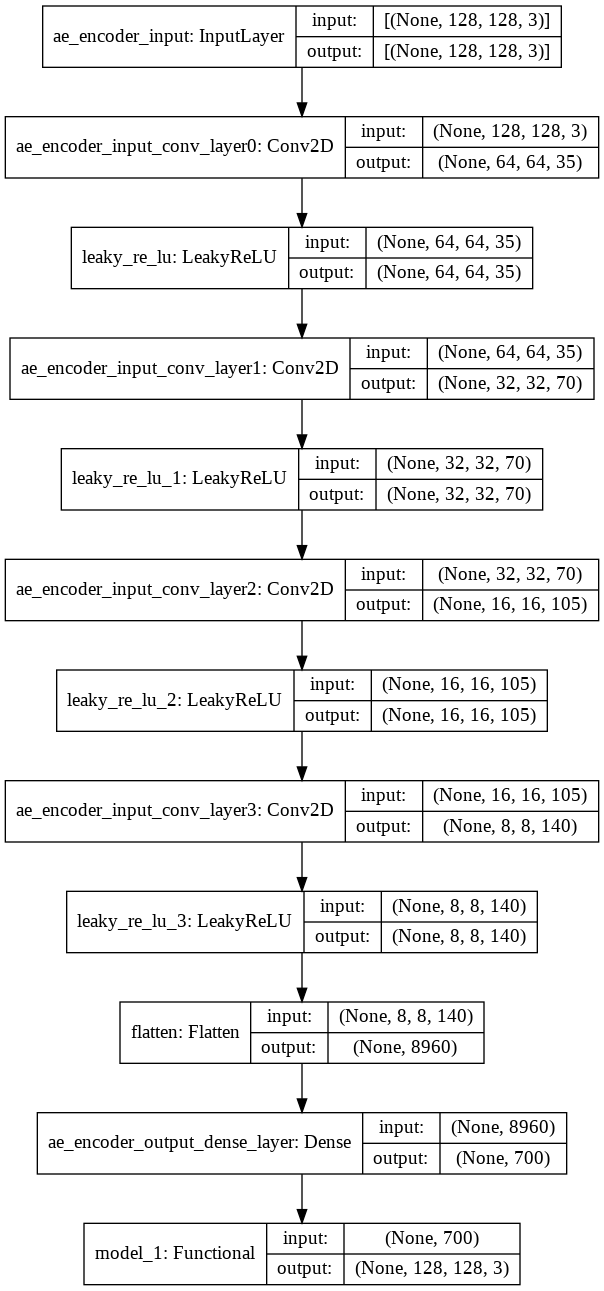

In [ ]:
tf.keras.utils.plot_model(autoencoder_model, show_shapes=True)

## Training the AE

Finally you will compile your autoencoer here. 

Here are few hyperparamters to consider here:
- Learning rate [0.1, 0.00001]
- Training epochs [5, 50]
- batch_size [64, 512]
- Latent vector size [20, 5000]
- Error function 
- Optimizer

In [ ]:
LEARNING_RATE = 0.003    # learning rate
N_EPOCHS = 10         # epochs
BATCH_SIZE = 500       # batch of images returned by image generator

######################## WRITE YOUR CODE BELOW ########################

# create custom_data_generator here
training = custom_image_generator(filenames, 7000)

# compile your model here
optimizer = Adam(lr=LEARNING_RATE)
autoencoder_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

########################### END OF YOUR CODE ##########################

Now simply call the <i>fit</i> function of the model with the appropriate paramters.

<i> HINT: Pass step_per_epoch to be equal to total images divided by batch_size. As you want to see all your data in a single epoch. </i>

In [ ]:
######################## WRITE YOUR CODE BELOW ########################

hist = autoencoder_model.fit(training, epochs=N_EPOCHS, steps_per_epoch=int(len(filenames) / BATCH_SIZE), verbose=1)

########################### END OF YOUR CODE ##########################

Epoch 1/10
140/140 [==============================] - 13s 91ms/step - loss: 0.0186 - mse: 0.0186
Epoch 2/10
140/140 [==============================] - 13s 92ms/step - loss: 0.0091 - mse: 0.0091
Epoch 3/10
140/140 [==============================] - 13s 92ms/step - loss: 0.0088 - mse: 0.0088
Epoch 4/10
140/140 [==============================] - 13s 92ms/step - loss: 0.0083 - mse: 0.0083
Epoch 5/10
140/140 [==============================] - 13s 92ms/step - loss: 0.0081 - mse: 0.0081
Epoch 6/10
140/140 [==============================] - 13s 92ms/step - loss: 0.0078 - mse: 0.0078
Epoch 7/10
140/140 [==============================] - 13s 92ms/step - loss: 0.0077 - mse: 0.0077
Epoch 8/10
140/140 [==============================] - 13s 92ms/step - loss: 0.0074 - mse: 0.0074
Epoch 9/10
140/140 [==============================] - 13s 92ms/step - loss: 0.0073 - mse: 0.0073
Epoch 10/10
140/140 [==============================] - 13s 92ms/step - loss: 0.0070 - mse: 0.0070


Mean Squared Error:  0.006926942616701126




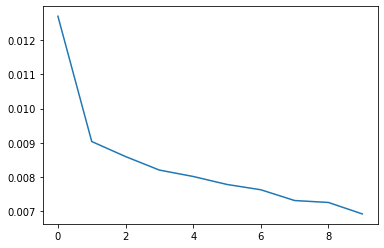

In [ ]:
print('Mean Squared Error: ', hist.history['mse'][-1])

print('')
print('')

pyplot.plot(hist.history['mse'])

## Reconstruction

Now we will get a batch of images from data generator object and try to reproduce it by passing through AE.

The first image grid shows the original images and the second grid shows the reconstructed images after passing it through the AE.

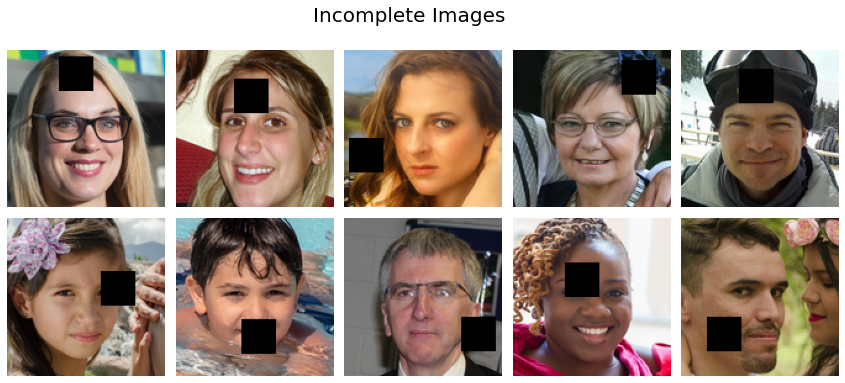

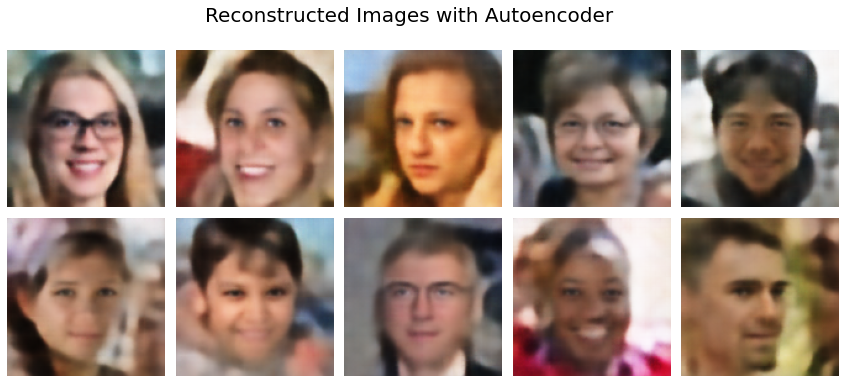

In [ ]:
test_gen = custom_image_generator(filenames, NUM_IMAGES)

test_batch = next(test_gen)[0]
test_images = test_batch[:10]

reconst_images = autoencoder_model.predict(test_images)

display_image_grid(test_images, 2, 5, "Incomplete Images")
display_image_grid(reconst_images, 2, 5, "Reconstructed Images with Autoencoder")

# REPORT

Report your results for different values of <b>Z_DIM</b>, <b>learning rate</b>, <b>optimizers</b>, <b> encoder and decoder model</b> and tell us for which configuration you acheived the best results (The best run model should be the last run model in this notebook, showing the results in the cell above).

## Making helper functions that will be called for different optimizers, Z values, Models, etc

In [ ]:
def generateEncoderDecoderModel(INPUT_DIM, filters, kernels, strides, Z_DIM, filters2, kernels2, strides2, nconv):
  # Generating Encoder
  ae_encoder = None # initialized below
  ae_encoder_output = None # initialized below
  ae_encoder_input = Input(shape=INPUT_DIM, name='ae_encoder_input')
  filters = filters
  kernels = kernels
  strides = strides
  ae = ae_encoder_input
  for i in range(nconv):
    ae = Conv2D(filters = filters[i], 
              kernel_size = kernels[i], 
              strides = strides[i], 
              padding = 'same', 
              name = 'ae_encoder_input_conv_layer' + str(i))(ae)
    ae = LeakyReLU()(ae)
  latentVectorReshaperHelper = K.int_shape(ae)[1:] 
  ae = Flatten()(ae)
  ae_encoder_output = Dense(Z_DIM, name='ae_encoder_output_dense_layer')(ae)
  ae_encoder = Model(inputs=ae_encoder_input, outputs=ae_encoder_output)

  # Generating Decoder
  ae_decoder = None # initialized below
  ae_decoder_output = None # initialized below
  filters2 = filters2
  kernels2 = kernels2
  strides2 = strides2
  ae_decoder_input = Input(shape=(Z_DIM,), name='ae_decoder_input')
  ae = Dense(np.prod(latentVectorReshaperHelper))(ae_decoder_input)
  ae = Reshape(latentVectorReshaperHelper)(ae)
  for i in range(nconv):
    ae = Conv2DTranspose(filters = filters2[i],
                        kernel_size = kernels2[i],
                        strides = strides2[i],
                        padding = 'same',
                        name = 'ae_decoder_output_dense_layer' + str(i))(ae)
    if i < nconv - 1:
      ae = LeakyReLU()(ae)
    else:
      ae = Activation('sigmoid')(ae)
  ae_decoder_output = ae
  ae_decoder = Model(inputs=ae_decoder_input, outputs=ae_decoder_output)

  # Attaching the Decoder to the Encoder
  autoencoder_model = None # initialized below
  ae_input = ae_encoder_input
  ae_output = ae_decoder(ae_encoder_output)
  autoencoder_model = Model(inputs=ae_input, outputs=ae_output)

  # Printing Summary
  autoencoder_model.summary()

  return autoencoder_model

In [ ]:
def trainMyModel(lr, epochs, batches, filenames, opt, model, l):
  LEARNING_RATE = lr
  N_EPOCHS = epochs
  BATCH_SIZE = batches
  training = custom_image_generator(filenames, 7000)
  optimizer = None
  if opt == 'Adam':
    optimizer = Adam(lr=LEARNING_RATE)
  elif opt == 'SGD':
    optimizer = SGD(lr=LEARNING_RATE)
  elif opt == 'Adagrad':
    optimizer = Adagrad(lr=LEARNING_RATE)
  model.compile(optimizer=optimizer, loss=l, metrics=['mse'])
  hist = model.fit(training, epochs=N_EPOCHS, steps_per_epoch=int(len(filenames) / BATCH_SIZE), verbose=1)
  return model, hist

In [ ]:
def printResults(filenames, NUM_IMAGES, model):
  test_gen = custom_image_generator(filenames, NUM_IMAGES)
  test_batch = next(test_gen)[0]
  test_images = test_batch[:10]
  reconst_images = model.predict(test_images)
  display_image_grid(test_images, 2, 5, "Incomplete Images")
  display_image_grid(reconst_images, 2, 5, "Reconstructed Images with Autoencoder")

Your answer:

## Model 1
Hyperparameters are mentioned as comments inside the cell

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_encoder_input (InputLayer [(None, 128, 128, 3)]     0         
_________________________________________________________________
ae_encoder_input_conv_layer0 (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
ae_encoder_input_conv_layer1 (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
ae_encoder_input_conv_layer2 (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 64)        0   

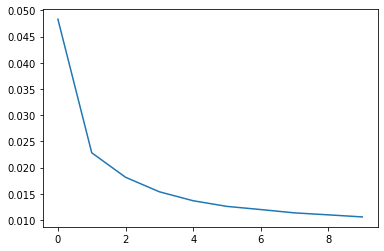

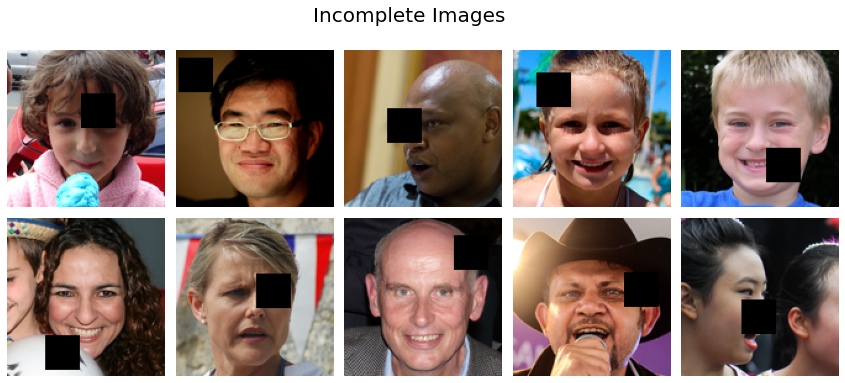

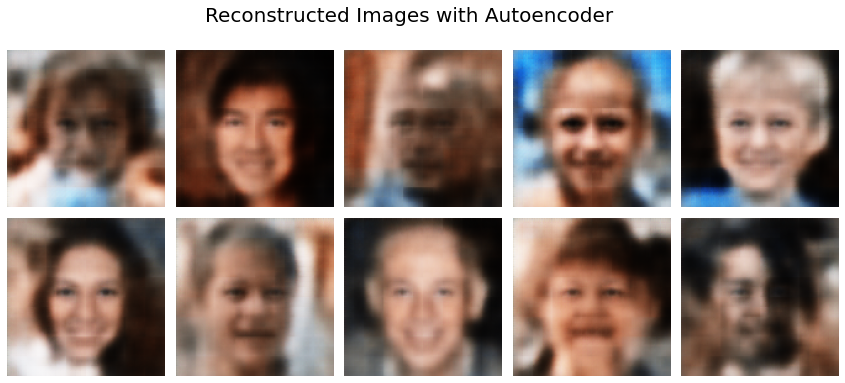

In [ ]:
'''
MODEL 1

INPUT_DIM = (128, 128, 3)
Z_DIM = 300
Number of Conv Layers = 4

-> for encoder
filters = [32, 64, 64, 64]
kernels = [3, 3, 3, 3]
strides = [2, 2, 2, 2]

-> for decoder
filters2 = [64, 64, 32, 3]
kernels2 = [3, 3, 3, 3]
strides2 = [2, 2, 2, 2]

-> compiling and training
Optimizer = Adam
Learning Rate = 0.0005
Epochs = 10
batch_size = 512
Loss = binary_crossentropy
'''

model1 = generateEncoderDecoderModel((128, 128, 3), [32, 64, 64, 64], [3, 3, 3, 3], [2, 2, 2, 2], 300, [64, 64, 32, 3], [3, 3, 3, 3], [2, 2, 2, 2], 4)

print('')
print('')

model1, hist = trainMyModel(0.0005, 10, 512, filenames, 'Adam', model1, 'binary_crossentropy')

print('')
print('')

print('Mean Squared Error: ', hist.history['mse'][-1])

print('')
print('')

pyplot.plot(hist.history['mse'])

print('')
print('')

printResults(filenames, NUM_IMAGES, model1)

## Model 2
Hyperparameters are mentioned as comments inside the cell

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_encoder_input (InputLayer [(None, 128, 128, 3)]     0         
_________________________________________________________________
ae_encoder_input_conv_layer0 (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
ae_encoder_input_conv_layer1 (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
ae_encoder_input_conv_layer2 (None, 16, 16, 96)        55392     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 16, 16, 96)        0   

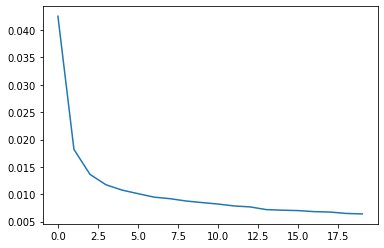

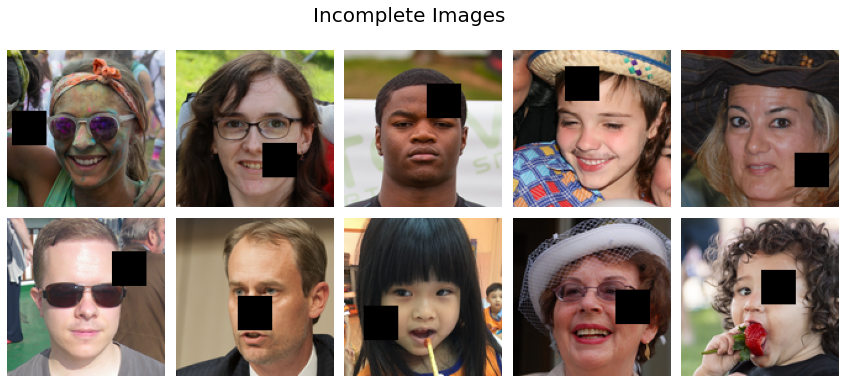

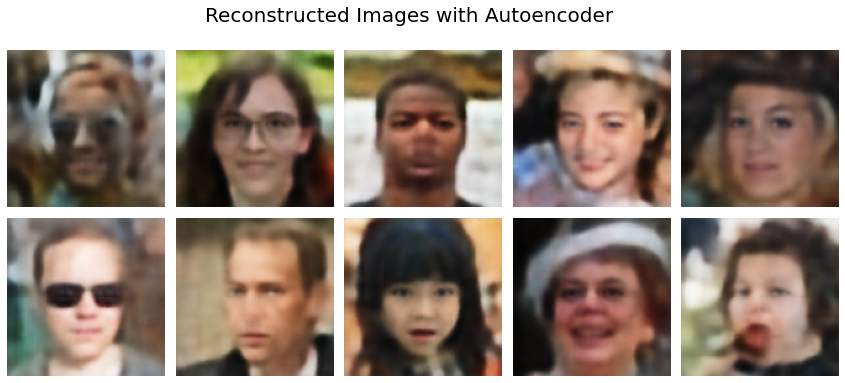

In [ ]:
'''
MODEL 2

INPUT_DIM = (128, 128, 3)
Z_DIM = 500
Number of Conv Layers = 4

-> for encoder
filters = [32, 64, 96, 128]
kernels = [3, 3, 3, 3]
strides = [2, 2, 2, 2]

-> for decoder
filters2 = [96, 64, 32, 3]
kernels2 = [3, 3, 3, 3]
strides2 = [2, 2, 2, 2]

-> compiling and training
Optimizer = Adam
Learning Rate = 0.001
Epochs = 20
batch_size = 512
Loss = mean_squared_error
'''

model2 = generateEncoderDecoderModel((128, 128, 3), [32, 64, 96, 128], [3, 3, 3, 3], [2, 2, 2, 2], 500, [96, 64, 32, 3], [3, 3, 3, 3], [2, 2, 2, 2], 4)

print('')
print('')

model2, hist = trainMyModel(0.001, 20, 512, filenames, 'Adam', model2, 'mean_squared_error')

print('')
print('')

print('Mean Squared Error: ', hist.history['mse'][-1])

print('')
print('')

pyplot.plot(hist.history['mse'])

print('')
print('')

printResults(filenames, NUM_IMAGES, model2)

## Model 3
Hyperparameters are mentioned as comments inside the cell

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_encoder_input (InputLayer [(None, 128, 128, 3)]     0         
_________________________________________________________________
ae_encoder_input_conv_layer0 (None, 64, 64, 40)        1120      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 64, 64, 40)        0         
_________________________________________________________________
ae_encoder_input_conv_layer1 (None, 32, 32, 80)        28880     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32, 32, 80)        0         
_________________________________________________________________
ae_encoder_input_conv_layer2 (None, 16, 16, 120)       86520     
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 16, 16, 120)       0  

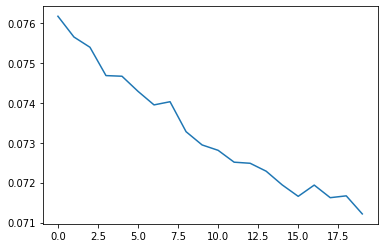

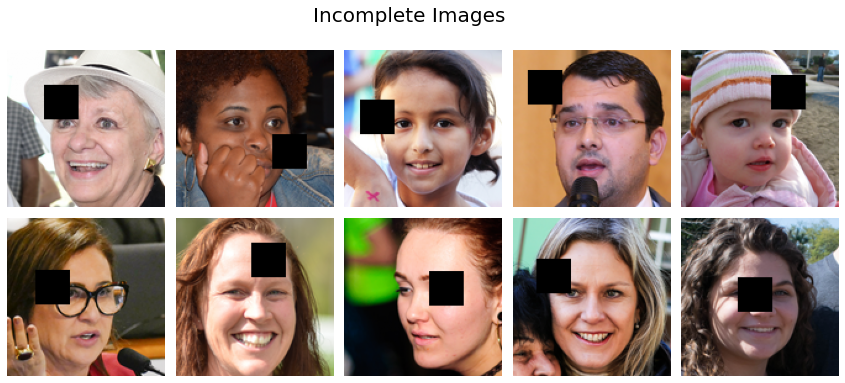

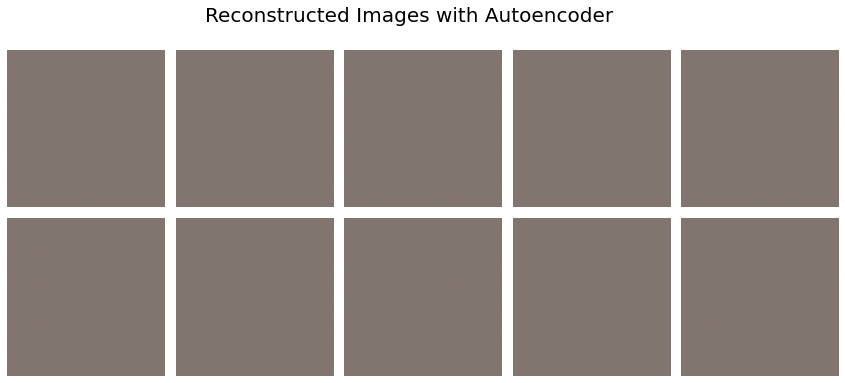

In [ ]:
'''
MODEL 3

INPUT_DIM = (128, 128, 3)
Z_DIM = 600
Number of Conv Layers = 4

-> for encoder
filters = [40, 80, 120, 160]
kernels = [3, 3, 3, 3]
strides = [2, 2, 2, 2]

-> for decoder
filters2 = [120, 80, 40, 3]
kernels2 = [3, 3, 3, 3]
strides2 = [2, 2, 2, 2]

-> compiling and training
Optimizer = SGD
Learning Rate = 0.005
Epochs = 20
batch_size = 450
Loss = mean_squared_error
'''

model3 = generateEncoderDecoderModel((128, 128, 3), [40, 80, 120, 160], [3, 3, 3, 3], [2, 2, 2, 2], 600, [120, 80, 40, 3], [3, 3, 3, 3], [2, 2, 2, 2], 4)

print('')
print('')

model3, hist = trainMyModel(0.005, 20, 450, filenames, 'SGD', model3, 'mean_squared_error')

print('')
print('')

print('Mean Squared Error: ', hist.history['mse'][-1])

print('')
print('')

pyplot.plot(hist.history['mse'])

print('')
print('')

printResults(filenames, NUM_IMAGES, model3)

## Model 4
Hyperparameters are mentioned as comments inside the cell

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_encoder_input (InputLayer [(None, 128, 128, 3)]     0         
_________________________________________________________________
ae_encoder_input_conv_layer0 (None, 64, 64, 40)        1120      
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 64, 64, 40)        0         
_________________________________________________________________
ae_encoder_input_conv_layer1 (None, 32, 32, 80)        28880     
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 32, 32, 80)        0         
_________________________________________________________________
ae_encoder_input_conv_layer2 (None, 16, 16, 120)       86520     
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 16, 16, 120)       0  

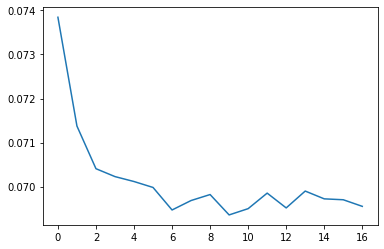

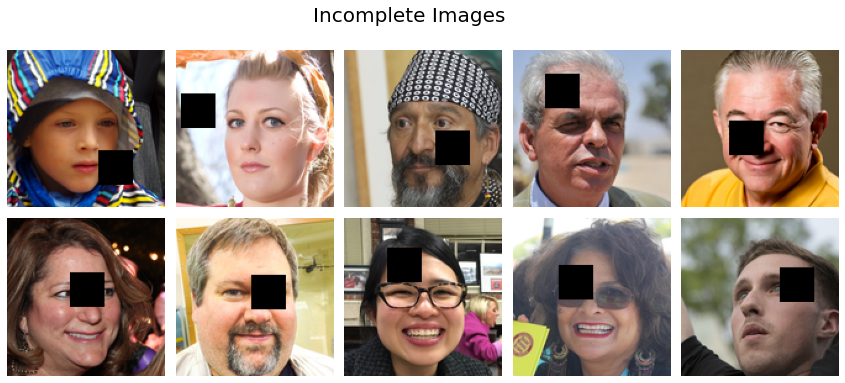

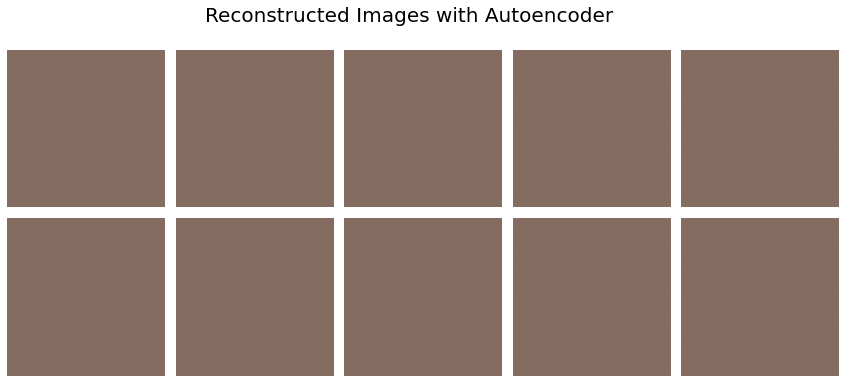

In [ ]:
'''
MODEL 4

INPUT_DIM = (128, 128, 3)
Z_DIM = 750
Number of Conv Layers = 4

-> for encoder
filters = [40, 80, 120, 160]
kernels = [3, 3, 3, 3]
strides = [2, 2, 2, 2]

-> for decoder
filters2 = [120, 80, 40, 3]
kernels2 = [3, 3, 3, 3]
strides2 = [2, 2, 2, 2]

-> compiling and training
Optimizer = Adagrad
Learning Rate = 0.01
Epochs = 17
batch_size = 300
Loss = binary_crossentropy
'''

model4 = generateEncoderDecoderModel((128, 128, 3), [40, 80, 120, 160], [3, 3, 3, 3], [2, 2, 2, 2], 750, [120, 80, 40, 3], [3, 3, 3, 3], [2, 2, 2, 2], 4)

print('')
print('')

model4, hist = trainMyModel(0.01, 17, 300, filenames, 'Adagrad', model4, 'binary_crossentropy')

print('')
print('')

print('Mean Squared Error: ', hist.history['mse'][-1])

print('')
print('')

pyplot.plot(hist.history['mse'])

print('')
print('')

printResults(filenames, NUM_IMAGES, model4)

## Model 5
Hyperparameters are mentioned as comments inside the cell

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_encoder_input (InputLayer [(None, 128, 128, 3)]     0         
_________________________________________________________________
ae_encoder_input_conv_layer0 (None, 64, 64, 40)        1120      
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 64, 64, 40)        0         
_________________________________________________________________
ae_encoder_input_conv_layer1 (None, 32, 32, 80)        28880     
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 32, 32, 80)        0         
_________________________________________________________________
ae_encoder_input_conv_layer2 (None, 16, 16, 120)       86520     
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 16, 16, 120)       0  

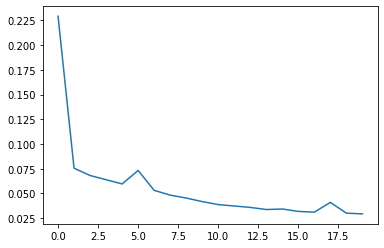

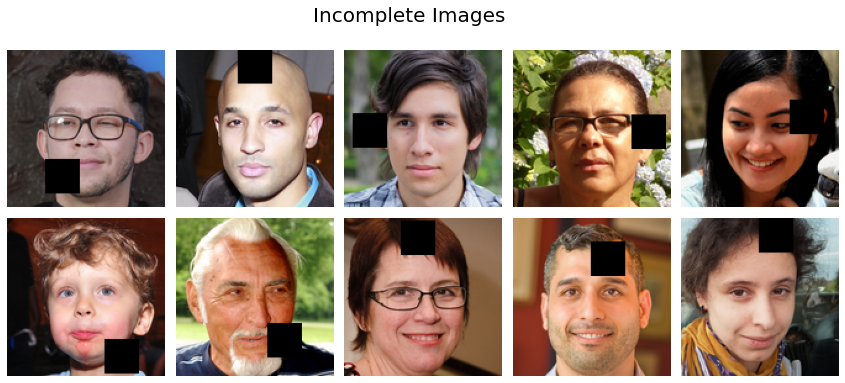

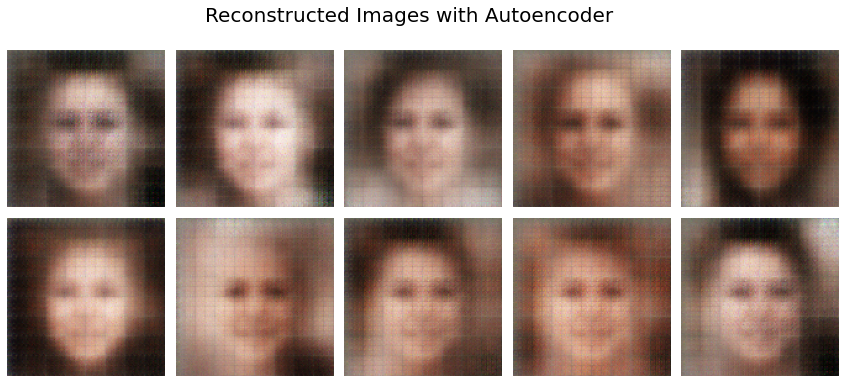

In [ ]:
'''
MODEL 5

INPUT_DIM = (128, 128, 3)
Z_DIM = 800
Number of Conv Layers = 4

-> for encoder
filters = [40, 80, 120, 160]
kernels = [3, 3, 3, 3]
strides = [2, 2, 2, 2]

-> for decoder
filters2 = [120, 80, 40, 3]
kernels2 = [3, 3, 3, 3]
strides2 = [2, 2, 2, 2]

-> compiling and training
Optimizer = Adam
Learning Rate = 0.008
Epochs = 20
batch_size = 450
Loss = binary_crossentropy
'''

model5 = generateEncoderDecoderModel((128, 128, 3), [40, 80, 120, 160], [3, 3, 3, 3], [2, 2, 2, 2], 800, [120, 80, 40, 3], [3, 3, 3, 3], [2, 2, 2, 2], 4)

print('')
print('')

model5, hist = trainMyModel(0.008, 20, 450, filenames, 'Adam', model5, 'binary_crossentropy')

print('')
print('')

print('Mean Squared Error: ', hist.history['mse'][-1])

print('')
print('')

pyplot.plot(hist.history['mse'])

print('')
print('')

printResults(filenames, NUM_IMAGES, model5)

## Model 6
Hyperparameters are mentioned as comments inside the cell

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_encoder_input (InputLayer [(None, 128, 128, 3)]     0         
_________________________________________________________________
ae_encoder_input_conv_layer0 (None, 64, 64, 35)        980       
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 64, 64, 35)        0         
_________________________________________________________________
ae_encoder_input_conv_layer1 (None, 32, 32, 70)        22120     
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 32, 32, 70)        0         
_________________________________________________________________
ae_encoder_input_conv_layer2 (None, 16, 16, 105)       66255     
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 16, 16, 105)       0  

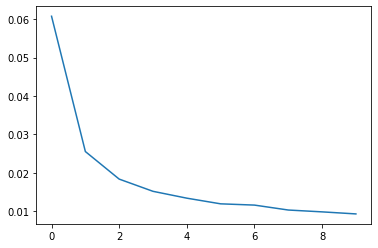

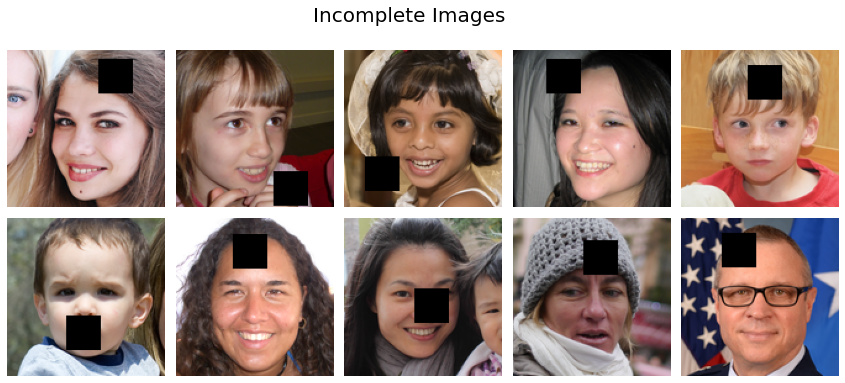

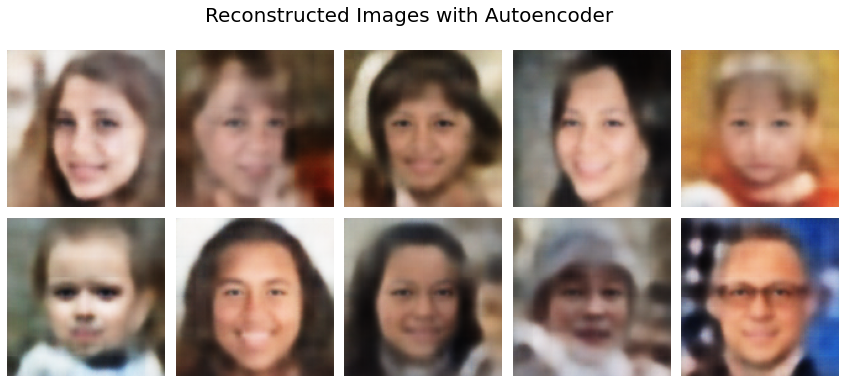

In [ ]:
'''
MODEL 6

INPUT_DIM = (128, 128, 3)
Z_DIM = 700
Number of Conv Layers = 4

-> for encoder
filters = [35, 70, 105, 140]
kernels = [3, 3, 3, 3]
strides = [2, 2, 2, 2]

-> for decoder
filters2 = [105, 70, 35, 3]
kernels2 = [3, 3, 3, 3]
strides2 = [2, 2, 2, 2]

-> compiling and training
Optimizer = Adam
Learning Rate = 0.003
Epochs = 10
batch_size = 500
Loss = mean_squared_error
'''

model6 = generateEncoderDecoderModel((128, 128, 3), [35, 70, 105, 140], [3, 3, 3, 3], [2, 2, 2, 2], 700, [105, 70, 35, 3], [3, 3, 3, 3], [2, 2, 2, 2], 4)

print('')
print('')

model6, hist = trainMyModel(0.003, 10, 500, filenames, 'Adam', model6, 'mean_squared_error')

print('')
print('')

print('Mean Squared Error: ', hist.history['mse'][-1])

print('')
print('')

pyplot.plot(hist.history['mse'])

print('')
print('')

printResults(filenames, NUM_IMAGES, model6)

## Observations

Out of the above 6 models, Model number 6 performed and reconstructed the best results whereas Models numbered 3 and 4 gave the worst results. 

With respect to loss functions, mean squared error proved to be the best. Although binary cross entropy gave satisfactory results as well but the results were a bit blurry. 

When it comes to optimizers, 3 different optimizers (Adam, Adagrad, and SGD) were used. Out of all these, only Adam gave satisfactory results. 

It was also noted epochs greater than 10 did not give best results. Mean squared error (metric) either remained almost constant or started to rise where epochs greater than 10 were used.

Various increasing and decreasing filter sizes and Z_DIMS were also used but they only proved effective if other factors such as choice for optimizer and loss functions were effective too. Hence, increasing Z_DIMS and filters sizes gave optimal results in Model 6.

Optimal learning rate was found to be between 0.0005 and 0.003.

Following configurations gave the best results among all tested:
INPUT_DIM = (128, 128, 3)
Z_DIM = 700
Number of Conv Layers = 4

-> for encoder
filters = [35, 70, 105, 140]
kernels = [3, 3, 3, 3]
strides = [2, 2, 2, 2]

-> for decoder
filters2 = [105, 70, 35, 3]
kernels2 = [3, 3, 3, 3]
strides2 = [2, 2, 2, 2]

-> compiling and training
Optimizer = Adam
Learning Rate = 0.003
Epochs = 10
batch_size = 500
Loss = mean_squared_error